## Objective
Test combining the DL model and propagation signal algorithm as described in "Propagation signal update" 3/20/23

In [2]:
# region Set up notebook imports
%load_ext autoreload
%autoreload
# Allow for imports of other scripts
import sys
PATH = "/data/MEAprojects/PropSignal"
if PATH not in sys.path:
    sys.path.append(PATH)
# Reload a module after changes have been made
from importlib import reload
# endregion

from src.sorters.dl_prop_signal import DLPropSignal

Make sf a variable and get rid of ccg params stuff


### Get propagations

In [3]:
%autoreload
import numpy as np
from pathlib import Path
import json
from src.prop_signal import v1_1, v1_2

In [4]:
# Load spike times
SPIKE_TIMES_PATH = Path("/data/MEAprojects/dandi/000034/sub-mouse412804/dl_spike_sorter/windows_200_120_spike_times.npy")
SPIKE_TIMES = np.load(SPIKE_TIMES_PATH, allow_pickle=True)

In [5]:
# Convert spike times to milliseconds
SAMPLING_FREQ = 30
##
spike_times = np.array([np.asarray(st) / SAMPLING_FREQ for st in SPIKE_TIMES], dtype=object)

In [85]:
# Save propagations
SAVE_PATH_PROP = SPIKE_TIMES_PATH.parent
PROP_SIGNAL_KWARGS = {
    "thresh_freq": 1,
    "seconds_recording": 900,
    "thresh_number_spikes": None,

    "ratio": 0.5,
    "thresh_cooccurrences_num": 250,
    "thresh_cooccurrences_p": 40,
    "p": 50,

    "elec_overlap_p": 10,
    "seq_order_p": 40,

    "small_window": 0.5,
    "big_window": 2,
    "ccg_before": 1.5,
    "ccg_after": 1.5,
    "ccg_n_bins": 91,
}

#### Revamp
scan_reference_electrode will take forever because so many spike times.

In [55]:
from tqdm import tqdm

In [82]:
# Worker init
sf = 30  # sampling frequency
thresh = 50
n_e = 248

electrode = 3
ref_spike_times = spike_times[electrode]


ccg_before = 1.5
ccg_after = 1.5
ccg_n_bins = 91
small_window = 0.5
big_window = 2
ratio = 0.5

ccg_mid_ind = int(ccg_n_bins // 2)
ccg_ind_factor = (ccg_n_bins - 1 - ccg_mid_ind) / ccg_after
#

# if len(ref_spike_times) < thresh: return None

elec_cohort = [(electrode, 0, ref_spike_times.size, 1)]

for electrode2 in tqdm(range(n_e)):
    if electrode2 == electrode: continue
    ccg = np.zeros(int((ccg_before + ccg_after) * sf) + 1)
    tar_spike_times = spike_times[electrode2]
    n_tar = tar_spike_times.size
    for ref in ref_spike_times:
        index = np.searchsorted(tar_spike_times, ref)

        if index == 0:
            tar = tar_spike_times[0]
        elif index == n_tar:
            tar = tar_spike_times[-1]
        else:
            left = tar_spike_times[index-1]
            right = tar_spike_times[index]
            if ref - left < right - ref:
                tar = left
            else:
                tar = right

        if tar >= ref-ccg_before and tar <= ref+ccg_after:
            bin = (tar - ref + ccg_before) * SAMPLING_FREQ
            ccg[round(bin)] += 1  # round because of floating point rounding error
    small_ind = round(small_window * sf) + 1
    loc = 0
    spikes_small_window = np.sum(ccg[:small_ind])
    sum_small_window = spikes_small_window
    for i in range(small_ind, len(ccg)):
        sum_small_window += -ccg[i-small_ind] + ccg[i]
        if sum_small_window > spikes_small_window:
            spikes_small_window = sum_small_window
            loc = i-small_ind+1

    delay = loc + np.argmax(ccg[loc:loc+small_ind])
    big_w = round(big_window * sf) // 2
    min_ind = max(0, delay - big_w)
    max_ind = delay + big_w + 1
    spikes_big_window = ccg[min_ind:max_ind].sum()

    if spikes_small_window >= ratio * spikes_big_window and spikes_big_window >= 1:
        time_delay = (delay - ccg_before) / SAMPLING_FREQ
        if time_delay >= -ccg_before:
            elec_cohort.append((electrode2, time_delay, spikes_small_window, spikes_small_window / spikes_big_window))

 32%|███▏      | 80/248 [00:39<01:22,  2.05it/s]


KeyboardInterrupt: 

<BarContainer object of 91 artists>

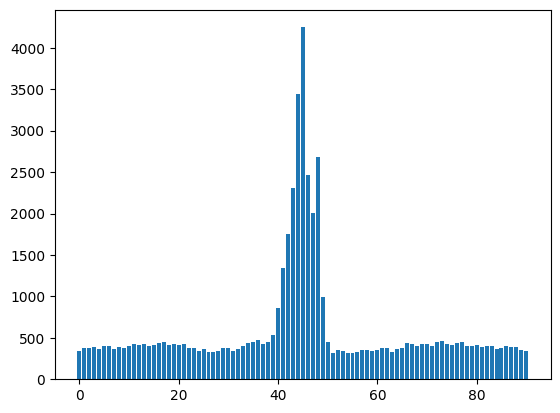

 60%|█████▉    | 148/248 [00:44<00:34,  2.89it/s]

In [28]:
import matplotlib.pyplot as plt
plt.bar(range(len(ccg)), ccg)

In [88]:
##
%autoreload
from src.prop_signal import v1_1, v1_2

candidate_cohorts = v1_1.scan_reference_electrode(spike_times, PROP_SIGNAL_KWARGS["thresh_freq"], PROP_SIGNAL_KWARGS["seconds_recording"], PROP_SIGNAL_KWARGS["thresh_number_spikes"], PROP_SIGNAL_KWARGS["ratio"], PROP_SIGNAL_KWARGS["small_window"], PROP_SIGNAL_KWARGS["big_window"], PROP_SIGNAL_KWARGS["ccg_before"], PROP_SIGNAL_KWARGS["ccg_after"], ccg_n_bins=SAMPLING_FREQ)

Scanning reference electrodes ...


100%|██████████| 248/248 [31:30<00:00,  7.62s/it] 


In [130]:
electrode_cohorts = v1_1.rescan_candidate_cohorts(candidate_cohorts, 250, 30, 50)

In [170]:
propagations = v1_2.get_propagations(electrode_cohorts)

In [171]:
len(propagations)

136

In [184]:
%autoreload
from src.prop_signal import v1_1, v1_2
propagations_merged = v1_2.merge_propagations(propagations, 40, 40)

In [185]:
len(propagations_merged)

106

In [186]:
sum(len(p) for p in propagations_merged)

136

In [6]:
# propagations = v1_2.prop_signal(spike_times, **PROP_SIGNAL_KWARGS)
np.save(str(SAVE_PATH_PROP / "propagations_merged.npy"), np.array(propagations_merged, dtype=object))
# np.save(str(path_root / "propagating_times.npy"), np.array(propagating_times, dtype=object))
with open(SAVE_PATH_PROP / "prop_params.json", "w") as f:
    json.dump(PROP_SIGNAL_KWARGS, f)

NameError: name 'SAVE_PATH_PROP' is not defined

### Get Templates
Templates = avg model output across all spike detections for each prop for each channel

In [6]:
SAVE_PATH_PROP = Path("/data/MEAprojects/dandi/000034/sub-mouse412804/dl_spike_sorter")
propagations_merged = np.load(SAVE_PATH_PROP / "propagations_merged.npy", allow_pickle=True)
propagations = []
for prop_m in propagations_merged:
    for p in prop_m:
        propagations.append(p)
propagations_merged = [[p] for p in propagations]

In [7]:
%autoreload
from src.sorters.dl_model import DLModelWindows
from scipy.special import expit as sigmoid
from tqdm import tqdm
from multiprocessing import Pool

In [8]:
model_windows = DLModelWindows("/data/MEAprojects/dandi/000034/sub-mouse412804/dl_spike_sorter/windows_200_120.npy", 120, 248,
                      "/data/MEAprojects/dandi/000034/sub-mouse412804/dl_spike_sorter/windows_200_120_outputs.npy")

In [9]:
def get_templates(pm_i):
    # Get templates of merged propagation
    prop_m = propagations_merged[pm_i]
    temp_m = []
    for prop in prop_m:
        temp = np.zeros((model_windows.num_chans, int(MS_BUFFER * 2 * SAMPLING_FREQ)), dtype="float32")
        ref_elec = prop.ID[0]
        ref_spike_times = spike_times[ref_elec][:]
        ref_spike_times_sel = set()  # Already selected
        for elec in prop.ID[1:]:
            tar_spike_times = spike_times[elec]
            n_tar = tar_spike_times.size
            for ref in ref_spike_times:
                if ref in ref_spike_times_sel:
                    continue

                index = np.searchsorted(tar_spike_times, ref)
                if index == 0:
                    tar = tar_spike_times[0]
                elif index == n_tar:
                    tar = tar_spike_times[-1]
                else:
                    left = tar_spike_times[index-1]
                    right = tar_spike_times[index]
                    if ref - left < right - ref:
                        tar = left
                    else:
                        tar = right

                if np.abs(ref - tar) <= MS_BUFFER:
                    window_idx, st_idx = model_windows.time_to_window(ref * SAMPLING_FREQ, ref_elec)
                    window_idx -= ref_elec
                    st_idx -= FRONT_BUFFER

                    # Sanity check that getting windows works
                    # import matplotlib.pyplot as plt
                    # plt.plot(sigmoid(model_windows.outputs[window_idx+ref_elec, :].flatten()))
                    # plt.plot(sigmoid(model_windows.outputs[window_idx+elec, :].flatten()))
                    # plt.axvline(st_idx)
                    # plt.show()
                    # break

                     # Handle if spike is on edge of model output
                    if st_idx - n_buffer < 0:
                        if window_idx - num_chans >= 0:
                            temp[:, :n_buffer-st_idx] += sigmoid(model_windows.outputs[window_idx - num_chans: window_idx, st_idx-n_buffer:])
                        temp[:, n_buffer-st_idx:] += sigmoid(model_windows.outputs[window_idx: window_idx + num_chans, :st_idx+n_buffer])
                    elif st_idx + n_buffer > model_windows.size_outputs:
                        n_over = st_idx + n_buffer - model_windows.size_outputs
                        temp[:, :-n_over] += sigmoid(model_windows.outputs[window_idx: window_idx + num_chans, st_idx-n_buffer:])
                        if window_idx + num_chans*2 <= len(model_windows):
                            temp[:, -n_over:] += sigmoid(model_windows.outputs[window_idx + num_chans: window_idx + num_chans*2, :n_over])
                    else:
                        temp += sigmoid(model_windows.outputs[window_idx: window_idx + num_chans, st_idx-n_buffer:st_idx+n_buffer])

                    ref_spike_times_sel.add(ref)
        temp /= len(ref_spike_times_sel)
        temp_m.append(temp)
        # break
    return temp_m

In [10]:
SAVE_PATH_TEMPLATES = SAVE_PATH_PROP / "templates.npy"
"""
For each propagation, an electrode's spike (excluding the first electrode)
will be considered to have led to the propagation being formed if it occurs
within +/- ms_buffer of a spike from the first electrode
"""
MS_BUFFER = 0.5
FRONT_BUFFER = 40  # DL model's
##
num_chans = model_windows.num_chans
n_buffer = int(MS_BUFFER * SAMPLING_FREQ)

templates = []
with Pool(processes=24) as pool:
    tasks = range(len(propagations_merged))
    for temp_m in tqdm(pool.imap(get_templates, tasks), total=len(tasks)):
        templates.append(temp_m)

100%|██████████| 136/136 [02:05<00:00,  1.09it/s]


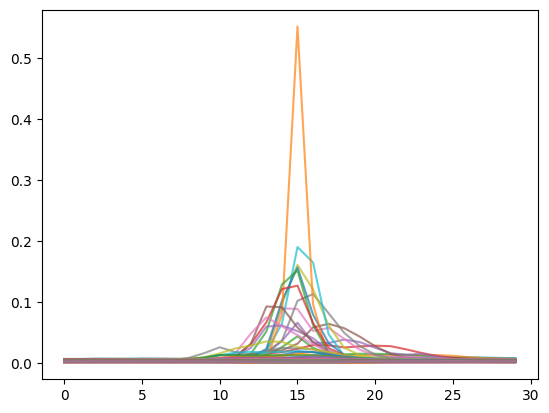

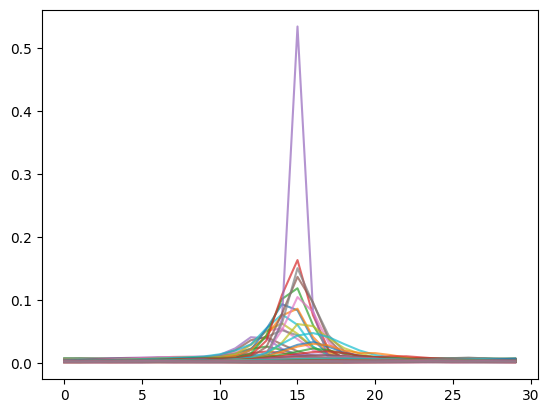

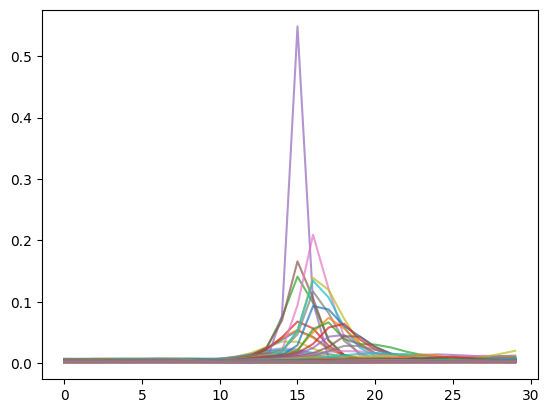

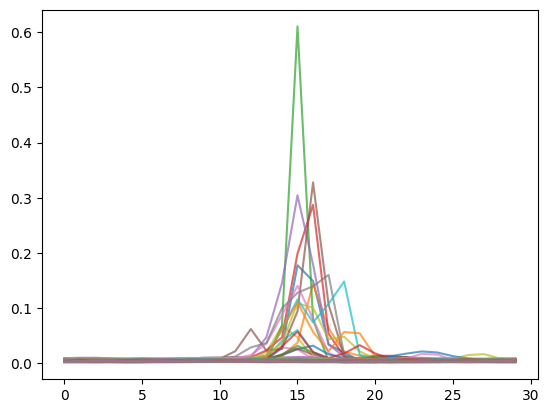

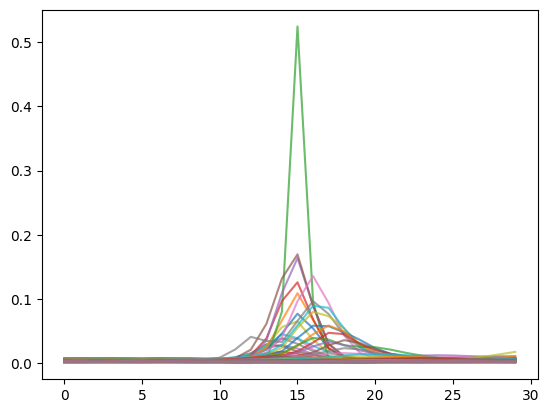

In [113]:
## Visualize some templates
import matplotlib.pyplot as plt
for i in np.random.choice(len(templates), 5):
    temp = templates[i]
    for t in np.random.choice(len(temp), 1):
        plt.plot(temp[t].T, alpha=0.7)
        plt.show()

In [11]:
# Reformat templates
prop_ids = []
templates_cat = []  # Keep track of which templates correspond to which propagations
for i, temp in enumerate(templates):
    for j, t in enumerate(temp):
        prop_ids.append([i, j])
        templates_cat.append(t.flatten())
templates_cat = np.vstack(templates_cat).T

## Get spike times

In [13]:
NUM_CHANNELS = 248

In [14]:
OUTPUTS_ALL = np.load("/data/MEAprojects/dandi/000034/sub-mouse412804/dl_spike_sorter/windows_200_120_outputs.npy", mmap_mode="r")
##
output_size = OUTPUTS_ALL.shape[1]
temp_size = templates_cat.shape[0] // NUM_CHANNELS

In [15]:
outputs_cat = []
for i in tqdm(range(0, len(OUTPUTS_ALL), NUM_CHANNELS)):
    outputs_cat.append(OUTPUTS_ALL[i: i+NUM_CHANNELS, :])
outputs_cat = np.hstack(outputs_cat)

100%|██████████| 224999/224999 [00:00<00:00, 273969.81it/s]


In [15]:
# WINDOWS_ALL = np.load("/data/MEAprojects/dandi/000034/sub-mouse412804/dl_spike_sorter/windows_200_120.npy", mmap_mode="r")
# windows_cat = []
# for i in tqdm(range(0, len(WINDOWS_ALL), NUM_CHANNELS)):
#     w = WINDOWS_ALL[i: i+NUM_CHANNELS, 0, 40:160]
#     windows_cat.append(w)
#
# windows_cat = np.hstack(windows_cat)

100%|██████████| 224999/224999 [00:01<00:00, 152762.65it/s]


In [ ]:
# TEMP_SIZE = 30
#
# def get_scores(i):
#     out = sigmoid(outputs_cat[:, i:i+TEMP_SIZE].flatten())
#     s = np.matmul(out, templates_cat)
#     return s
# from multiprocessing import Pool
#
# p_scores = []
# with Pool(processes=24) as pool:
#     tasks = range(0, outputs_cat.shape[1]-TEMP_SIZE)
#     for s in tqdm(pool.imap(get_scores, tasks, chunksize=1000), total=len(tasks)):
#         p_scores.append(s)

 76%|███████▋  | 20600001/26999850 [54:59<16:46, 6359.63it/s]  

In [18]:
from scipy.signal import find_peaks
for k in tqdm(outputs_cat):
    find_peaks(k, height=10)

100%|██████████| 248/248 [00:44<00:00,  5.52it/s]


In [22]:
prop_scores = np.zeros((templates_cat.shape[1], outputs_cat.shape[1]-TEMP_SIZE), dtype="float16")
np.save("/data/MEAprojects/dandi/000034/sub-mouse412804/dl_spike_sorter/prop_scores.npy", prop_scores)
prop_scores = np.load("/data/MEAprojects/dandi/000034/sub-mouse412804/dl_spike_sorter/prop_scores.npy", mmap_mode="r+")

In [23]:
from scipy.signal import find_peaks
THRESH = 0.7
TEMP_SIZE = 30

def get_scores(i):
    out = sigmoid(outputs_cat[:, i:i+TEMP_SIZE].flatten())
    s = np.matmul(out, templates_cat)
    prop_scores[:, i] = s

from multiprocessing import Pool

with Pool(processes=24) as pool:
    tasks = range(0, outputs_cat.shape[1]-TEMP_SIZE)
    for s in tqdm(pool.imap(get_scores, tasks, chunksize=1000), total=len(tasks)):
        pass

100%|██████████| 26999850/26999850 [59:15<00:00, 7594.41it/s]  


#### Visualization
Look at some prop scores

In [16]:
import matplotlib.pyplot as plt

In [32]:
WINDOWS_ALL = np.load("/data/MEAprojects/dandi/000034/sub-mouse412804/dl_spike_sorter/windows_200_120.npy", mmap_mode="r")

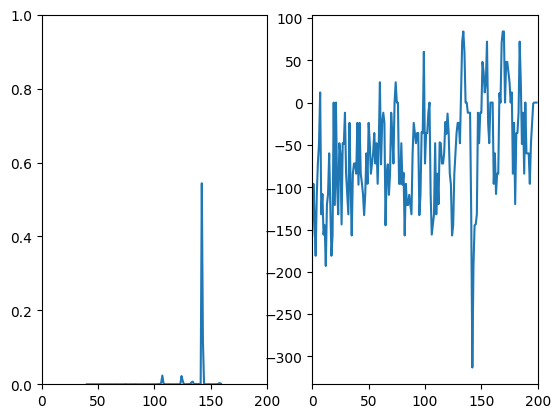

In [308]:
OUTPUT_IDX = NUM_CHANNELS * 112311
CHAN = 80
##
window = WINDOWS_ALL[OUTPUT_IDX: OUTPUT_IDX + NUM_CHANNELS, 0, :]
output = sigmoid(OUTPUTS_ALL[OUTPUT_IDX: OUTPUT_IDX + NUM_CHANNELS, :])
output = output[CHAN]
window = window[CHAN]

fig, (a0, a1) = plt.subplots(1, 2)

a0.plot(range(40, 160), output.T)
a0.set_xlim(0, 200)
a0.set_ylim(0, 1)

a1.plot(window.T)
a1.set_xlim(0, 200)
plt.show()

#### Return

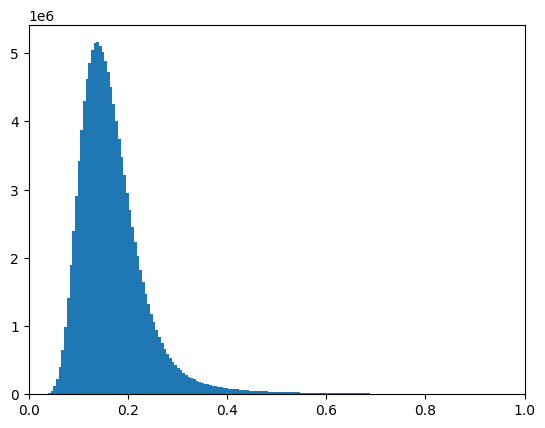

In [33]:
plt.hist(prop_scores.flatten(), bins=500)
plt.xlim(0, 1)
plt.show()

In [89]:
THRESH = 0.6
np.sum(prop_scores >= THRESH)

686147

In [63]:
# THRESH = 1
# STRIDE = 120
# FRONT_BUFFER = 40
# ##
# out_split = output_size // temp_size
#
# prop_spike_times_all = [[] for _ in range(len(propagations_merged))]
# for prop_i, scores in tqdm(enumerate(prop_scores.T), total=prop_scores.shape[1]):
#     score_ind = np.flatnonzero(scores >= THRESH)
#     prop_id, m_id = prop_ids[prop_i]
#     chan_max = propagations_merged[prop_id][m_id].ID[0]
#     for score_i in score_ind:
#         i, j = prop_ind[score_i]
#         out = sigmoid(OUTPUTS_ALL[i+chan_max, j:j+temp_size])
#
#         st = (i / NUM_CHANNELS * STRIDE) + (j + np.argmax(out)) + FRONT_BUFFER
#         prop_spike_times_all[prop_id].append(int(st))
# prop_spike_times_all = [np.unique(pst) for pst in prop_spike_times_all]

100%|██████████| 136/136 [00:02<00:00, 50.43it/s]


In [90]:
STRIDE = 120
FRONT_BUFFER = 40
##
out_split = output_size // temp_size

prop_spike_times_all = []
for prop_i, scores in tqdm(enumerate(prop_scores.T), total=prop_scores.shape[1]):
    score_ind = np.flatnonzero(scores >= THRESH)
    prop_id, m_id = prop_ids[prop_i]
    chan_max = propagations_merged[prop_id][m_id].ID[0]
    pst = []
    for score_i in score_ind:
        i, j = prop_ind[score_i]
        out = sigmoid(OUTPUTS_ALL[i+chan_max, j:j+temp_size])

        st = (i / NUM_CHANNELS * STRIDE) + (j + np.argmax(out)) + FRONT_BUFFER
        pst.append(int(st))
    prop_spike_times_all.append(pst)
prop_spike_times_all = [np.unique(pst) for pst in prop_spike_times_all]

100%|██████████| 136/136 [00:08<00:00, 16.61it/s]


5045.198529411765
1767.2023912015356


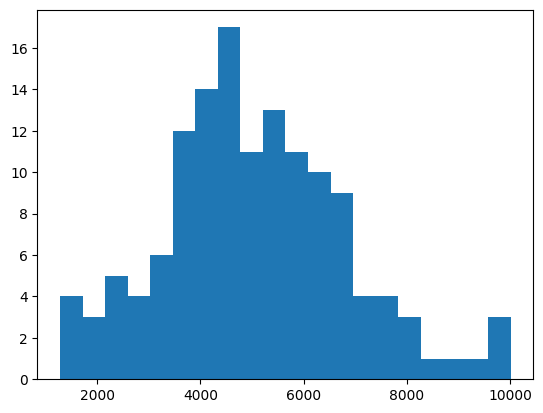

In [99]:
lengths = [len(st) for st in prop_spike_times_all]
plt.hist(lengths, bins=20)
print(np.mean(lengths))
print(np.std(lengths))
plt.show()

In [29]:
prop_scores = np.load("/data/MEAprojects/dandi/000034/sub-mouse412804/dl_spike_sorter/prop_scores.npy", mmap_mode="r")

In [55]:
from scipy.signal import find_peaks
THRESH = 0.9
prop_spike_times_all = []
for i in tqdm(range(prop_scores.shape[0])):
    scores = prop_scores[i, :]
    prop_id, m_id = prop_ids[i]
    chan = propagations_merged[prop_id][m_id].ID[0]

    peaks = find_peaks(scores, height=THRESH)[0]
    prop_st = []
    for peak in peaks:
        out = outputs_cat[chan, peak:peak+TEMP_SIZE]
        st = np.argmax(out)
        prop_st.append(peak + st + 40)  # + front buffer
    prop_spike_times_all.append(prop_st)
prop_spike_times_all = [np.unique(st) for st in prop_spike_times_all]

100%|██████████| 136/136 [00:33<00:00,  4.06it/s]


In [33]:
prop_scores.shape

(136, 26999850)

## Compare to Kilosort2

In [35]:
from src.sorters.kilosort import Kilosort
from src import utils
from src.comparison import Comparison

In [36]:
class DLProp:
    def __init__(self):
        self.name = "DLProp"

    def get_spike_times(self):
        return [np.asarray(pst) / SAMPLING_FREQ for pst in prop_spike_times_all]
        # test = "/data/MEAprojects/DLSpikeSorter/models/v0_4_4/2953/230101_133514_582221/log/prop_signal/default/propagating_times.npy"
        # test = np.load(test, allow_pickle=True)
        # return [t[-1] for t in test]

    def plot_isis(self, isi_viol=1.5, **hist_kwargs):
        violations = []
        for unit in self.get_spike_times():
            isis = np.diff(unit)
            violation_num = np.sum(isis < isi_viol)
            violations.append(violation_num / len(unit) * 100)

        plt.hist(violations, **hist_kwargs)
        plt.title("ISI violation distribution.")
        plt.xlabel("Percent ISI violations")
        plt.ylabel("Count")
        plt.show()

        return violations

In [37]:
kilosort = Kilosort(utils.PATH_SM4_SI, "initial", utils.PATH_REC_SI)

/home/mea/anaconda3/envs/allen_inst/lib/python3.7/site-packages/hdmf/spec/namespace.py:532: UserWarning: Ignoring cached namespace 'hdmf-common' version 1.1.3 because version 1.5.1 is already loaded.
  % (ns['name'], ns['version'], self.__namespaces.get(ns['name'])['version']))
/home/mea/anaconda3/envs/allen_inst/lib/python3.7/site-packages/hdmf/spec/namespace.py:532: UserWarning: Ignoring cached namespace 'core' version 2.2.5 because version 2.5.0 is already loaded.
  % (ns['name'], ns['version'], self.__namespaces.get(ns['name'])['version']))
/home/mea/anaconda3/envs/allen_inst/lib/python3.7/site-packages/pynwb/ecephys.py:93: UserWarning: ElectricalSeries 'ElectricalSeries': The second dimension of data does not match the length of electrodes. Your data may be transposed.
  "Your data may be transposed." % (self.__class__.__name__, kwargs["name"]))


In [38]:
len(kilosort.spike_times) / 4

411143.75

In [40]:
import matplotlib.pyplot as plt

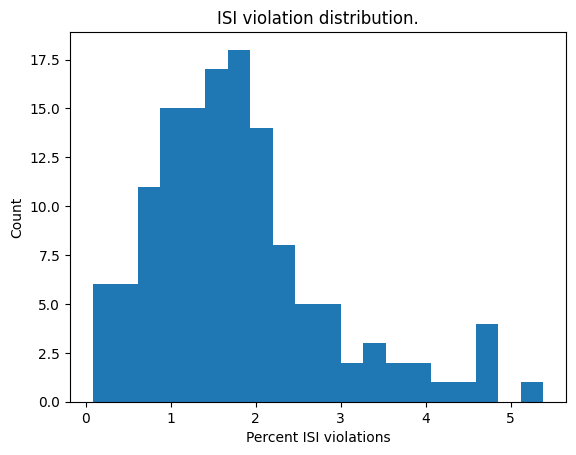

In [56]:
dlprop = DLProp()
viols = dlprop.plot_isis(bins=20)
v_idx = np.argmax(viols)

In [42]:
propagations_merged[v_idx]

[     ID   latency  small_window_cooccurrences  n1_n2_ratio
 0   151  0.000000                    115988.0     1.000000
 1   155  1.383333                     39513.0     0.766558
 2   156  1.383333                     34951.0     0.738064
 3   146  1.416667                     44743.0     0.751971
 4   149  1.450000                     57976.0     0.853153
 5   148  1.450000                     56152.0     0.858711
 6   153  1.450000                     51962.0     0.846011
 7   152  1.450000                     49966.0     0.828912
 8   150  1.450000                     46495.0     0.801486
 9   144  1.450000                     36383.0     0.698652
 10  147  1.483333                     51212.0     0.818973
 11  145  1.516667                     40018.0     0.719619]

Getting match counts and agreement scores


100%|██████████| 136/136 [01:21<00:00,  1.67it/s]

Matches/Num Kilosort2: 0/424


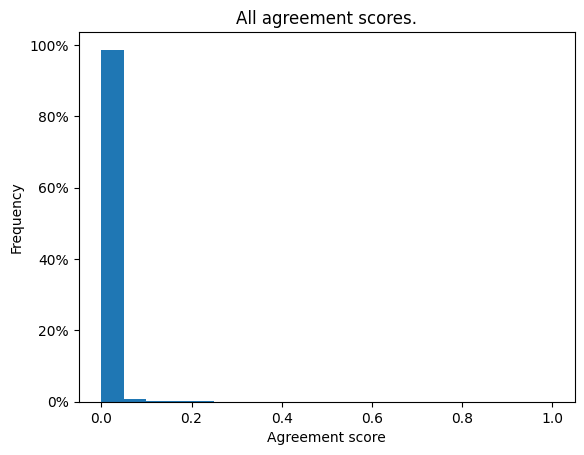

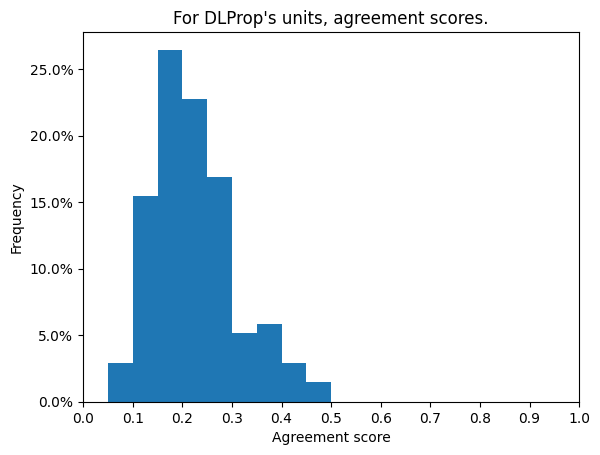

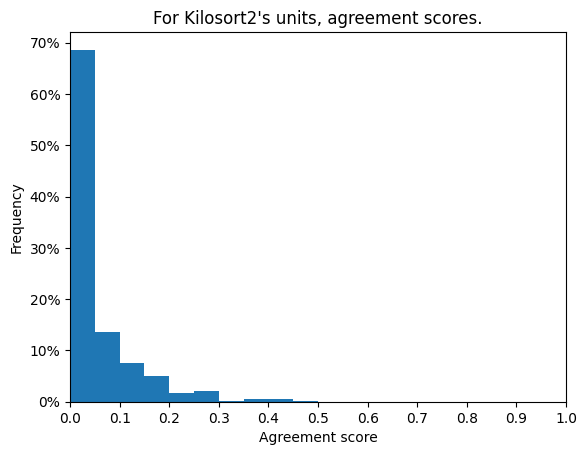

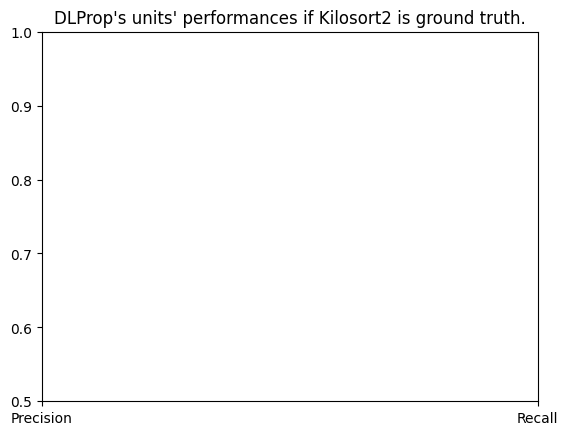

In [57]:
comparison = Comparison(dlprop, kilosort, delta_time=0.8)

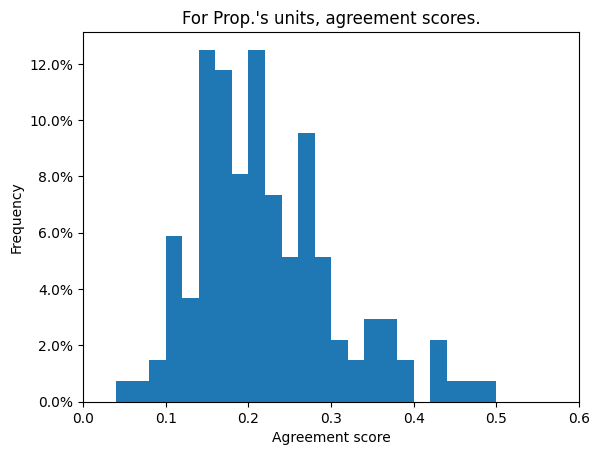

In [63]:
plt.title(f"For Prop.'s units, agreement scores.")
from src.plot import plot_hist_percents
plot_hist_percents(np.max(comparison.agreement_scores, axis=1), range=(0, 1), bins=50)
plt.xlabel("Agreement score")
plt.xticks([x/10 for x in range(11)])
plt.xlim(0, 0.6)
plt.show()

In [42]:
test = kilosort.get_spike_times()

In [43]:
t = max(max(asf) for asf in test)

In [44]:
t / 1000 / 60

14.999995

In [45]:
kilosort_times = []
for unit in kilosort.get_spike_times():
    kilosort_times.extend(unit)

In [46]:
prop_times = []
for unit in dlprop.get_spike_times():
    prop_times.extend(unit)

In [64]:
print(len(kilosort_times))
print(len(prop_times))
matching = Comparison.count_matching_events(kilosort_times, prop_times, delta=0.4)
print(matching)
print(matching/len(kilosort_times))
print(matching/len(prop_times))

1644575
7031574
1224051
0.7442962467506803
0.17407923176233372
